In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import xarray as xr
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [2]:
#generate pd DataFrame with all PSMSL measurements
import zipfile
import io
import sys
import requests

sys.path.append(r'c:\DATA\sealevel') #https://github.com/openearth/sealevel/tree/master/lib
from lib import psmsl, models
resp = requests.get('http://www.psmsl.org/data/obtaining/rlr.annual.data/rlr_annual.zip')

stream = io.BytesIO(resp.content)
zf = zipfile.ZipFile(stream)

stations = pd.read_csv(
    io.BytesIO(zf.read('rlr_annual/filelist.txt')),  
    sep=';', 
    names=('id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality'),
    converters={
        'name': str.strip,
        'quality': str.strip
    }
)
stations = stations.set_index('id')

measurements = []
for i, station in stations.iterrows():
    df = psmsl.get_data(zf, station, 'rlr_annual')
    measurements.append(df)
measurements = pd.concat(measurements)
measurements['height'] = measurements['height']/1000-7 #correction from mm to m arbitrary 7m mean.
measurements

,year,height,interpolated,flags,station
t,,,,,
1807-01-01,1807.0,-0.030,N,10,1
1808-01-01,1808.0,-0.132,N,10,1
1809-01-01,1809.0,-0.046,N,10,1
1810-01-01,1810.0,-0.053,N,10,1
1811-01-01,1811.0,-0.024,N,10,1
...,...,...,...,...,...
2016-01-01,2016.0,-0.364,Y,0,2360
2017-01-01,2017.0,-0.317,N,0,2360
2018-01-01,2018.0,-0.393,N,0,2360


In [3]:
# load a  colormap from https://www.fabiocrameri.ch/colourmaps/
%run cmap.py
romaO
tokyo

# Introduction
This notebook is the analysis of GTSM nodal tide reanalysis run. In this run we simulate 19 years of just tidal forcing. The main research question is how does the nodal tide, the 18.613 cycle, affect the mean sea level and the tidal range. This question is relevant to be able to accurately assess the local sea-level rise. It can also help to predict so called king tides. The nodal tide is also known to affect cycles in vegetation and morphology in areas with higher tidal amplitude and shallow shores.  

We use the following model run.
- Schematization: GTSMv3.0EMODnet
- Bathymetry: EMODnet2020
- Run: production_runs_2021 (No Wind, No Waves, All tidal constituents active)
- Runtime 1999-2017


In [4]:
# All results (postprocessed using CDO for annual mean/min/max are stored here)
data_dir = '/Users/baart_f/data/gtsm/nodal'
data_dir = r'c:\DATA\sealevel_data'
ds_mean = xr.open_mfdataset(data_dir + '/EM_*_YEARMEAN_his.nc', combine='by_coords')
ds_monmean = xr.open_mfdataset(data_dir + '/EM_*_MONMEAN_his.nc', combine='by_coords')
ds_max = xr.open_mfdataset(data_dir + '/EM_*_YEARMAX_his.nc', combine='by_coords')
ds_min = xr.open_mfdataset(data_dir + '/EM_*_YEARMIN_his.nc', combine='by_coords')

In [5]:
#retrieve station names from hisfile (they were lost with cdo commands for subset netcdf files)
try:
    from dfm_tools.get_nc_helpers import get_hisstationlist
    file_his = data_dir + '/EM_19990101_0000_short_his.nc'
    #file_his = r'p:\\1230882-emodnet_hrsm\\GTSMv3.0EMODnet\\EMODnet2020\\production_runs_2021\\EM_19990101\\EM_19990101_0000_his.nc'
    stations_pd = get_hisstationlist(file_nc=file_his,varname='waterlevel')
except:
    print('if you want station names in the dataframes, install dfm_tools in your environment (pip install git+https://github.com/openearth/dfm_tools)')


# Checks

In [6]:
dates  = ds_mean.waterlevel.time.values.astype('M8[ms]').astype('O')
# we'll just use the years
# This assumes that annual waterlevels are used that are stored left-padded, the mean waterlevel for 2020 is stored as 2020-1-1
# This is not logical, but common practice.
year = np.array([x.year for x in dates], dtype='double')

assert  np.allclose(np.diff(year), 1), f'all years should be sequential: {year}'
# show all the years
year


array([1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006., 2007.,
       2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015., 2016.,
       2017.])

In [7]:
lon = ds_mean.waterlevel.station_x_coordinate.values
lat = ds_mean.waterlevel.station_y_coordinate.values
dep = ds_mean.bedlevel.values[0,:]

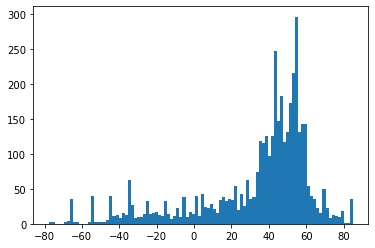

In [8]:
# Using the PSMSL and EU stations gives a skewness towards higher latitudes 
# (normalize in results)
plt.hist(lat, bins=100);

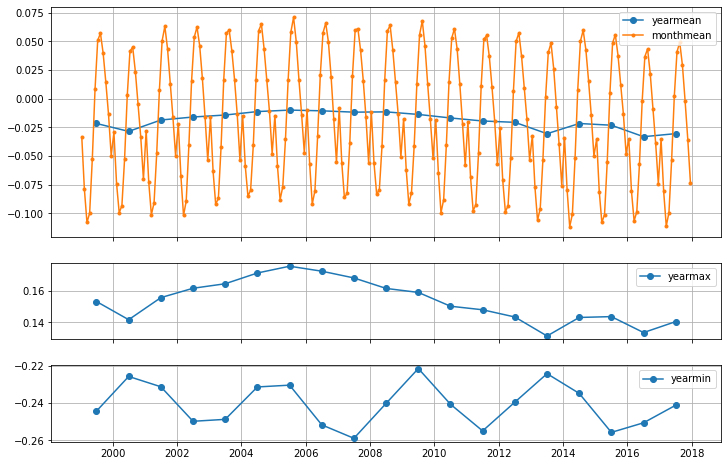

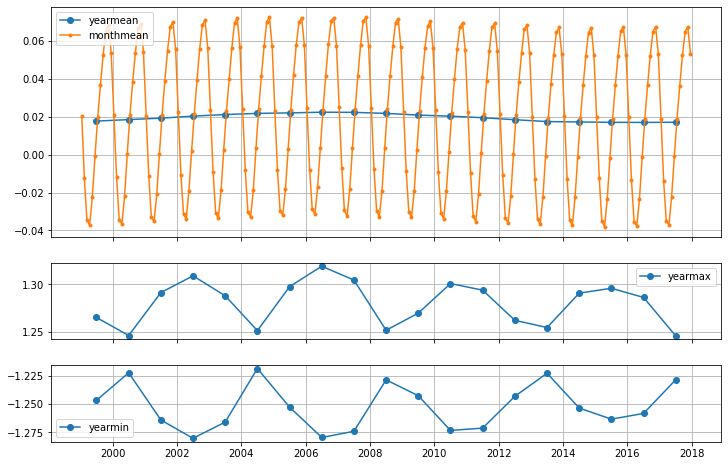

In [9]:
# plot the datasets to check if they are correct.
# there seems to be something wrong for 2014 and 2015 (visible in yearmean and yearmax)
# also december seems off for the monthmeans, this might be because the spinup in december of the previous year is included in the montmean (although this should not be the case)
# yearmin shows a non-nodal pattern
fig,(ax1,ax2,ax3) = plt.subplots(3,1, figsize=(12,8), gridspec_kw={'height_ratios':[3,1,1]},sharex=True)
wllines = ax1.plot(ds_mean['time'],ds_mean['waterlevel'][:,0], 'o-',label='yearmean')
wllines = ax1.plot(ds_monmean['time'],ds_monmean['waterlevel'][:,0], '.-',label='monthmean')
wllines = ax2.plot(ds_max['time'],ds_max['waterlevel'][:,0], 'o-',label='yearmax')
wllines = ax3.plot(ds_min['time'],ds_min['waterlevel'][:,0], 'o-',label='yearmin')
for ax in (ax1,ax2,ax3):
    ax.legend(loc=0)
    ax.grid()
fig,(ax1,ax2,ax3) = plt.subplots(3,1, figsize=(12,8), gridspec_kw={'height_ratios':[3,1,1]},sharex=True)
wllines = ax1.plot(ds_mean['time'],ds_mean['waterlevel'].mean(axis=1), 'o-',label='yearmean')
wllines = ax1.plot(ds_monmean['time'],ds_monmean['waterlevel'].mean(axis=1), '.-',label='monthmean')
wllines = ax2.plot(ds_max['time'],ds_max['waterlevel'].mean(axis=1), 'o-',label='yearmax')
wllines = ax3.plot(ds_min['time'],ds_min['waterlevel'].mean(axis=1), 'o-',label='yearmin')
for ax in (ax1,ax2,ax3):
    ax.legend(loc=0)
    ax.grid()

# Mean sea level analysis
We will first analyse mean sea level. For this we will use a simple [harmonic fit](https://www.researchgate.net/profile/Phajm-Gelder/publication/236019217_The_Effect_of_the_186-Year_Lunar_Nodal_Cycle_on_Regional_Sea-Level_Rise_Estimates/links/0deec533fc3c070917000000/The-Effect-of-the-186-Year-Lunar-Nodal-Cycle-on-Regional-Sea-Level-Rise-Estimates.pdf) where we include two linearized components for the nodal tide and a constant sea-level. Using this harmonic fit we estimate the phase, amplitude and mean sea level using an ordinary least squared regression fit. From this fit, we can compute the phase and amplitude per station. 



In [10]:
"""define a simple linear model, with nodal tide and without wind """
X = np.c_[
    np.cos(2*np.pi*(year - 1970)/18.613),
    np.sin(2*np.pi*(year - 1970)/18.613)
]

X = sm.add_constant(X)
Y = ds_mean.waterlevel.values
names = ['Constant', 'Nodal U', 'Nodal V']
model = sm.OLS(Y, X, missing='drop')
fit = model.fit()
Constant = fit.params[0]
A = fit.params[1]
B = fit.params[2]
phase = np.arctan2(B, A)
amplitude = np.sqrt(A**2 + B**2)


# Check mean sea level
First we check if the mean water level is approximately 0. Possible cause for deviation is that we are using a non-uniform gravity map. 

Then we check if the constant water level is almost equal to the mean water level. If that's the case this histogram should be centered around 0. If this is not the case, we might want to examine a few of the extremes. Other causes for deviations include using a slightly longer time window (we now have exactly one cycle).

,lat,lon,dep,mean_waterlevel,amplitude,station_name
2823,46.860351,-71.088867,-11.003339,3.387255,0.008704,psmsl-173
603,16.479492,97.602539,-8.821159,1.512246,0.030938,moulmein
3435,61.245114,-149.912109,-7.503355,1.380460,0.033137,psmsl-1067
3032,59.326171,-135.366211,-11.571979,1.163982,0.033994,psmsl-495
3941,36.958007,126.811523,-11.777194,0.715108,0.024142,psmsl-1908
1068,49.445801,0.314941,-5.852910,0.700016,0.023753,IBIS_GL_TS_MO_62449
4157,51.569824,-2.702637,-6.933334,0.556875,0.018744,psmsl-2285
1130,51.511230,-2.717285,-7.182796,0.545699,0.018408,IBIS_IR_TS_MO_Avonmouth
1204,51.496582,-2.731934,-6.431455,0.535976,0.018089,IBIS_IR_TS_MO_Portbury
1326,53.327636,7.243652,-5.334447,0.459714,0.002676,NWS_NO_TS_MO_Emden


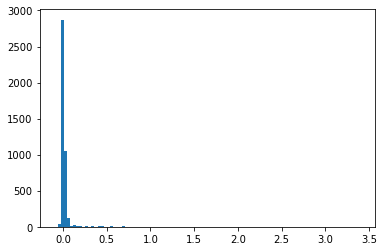

In [11]:

# Check exeptional waterlevels
mean_waterlevel = np.nanmean(ds_mean.waterlevel.values, axis=0)
plt.hist(mean_waterlevel, bins=100);
df = pd.DataFrame(data=dict(lat=lat, lon=lon, dep=dep, mean_waterlevel=mean_waterlevel, amplitude=amplitude))
if 'stations_pd' in locals():
    df['station_name'] = stations_pd.loc[:,'station_id']
df = df.drop_duplicates(['lat', 'lon'])

# top 10 highest mean water levels
df.sort_values('mean_waterlevel', ascending=False).head(n=20)

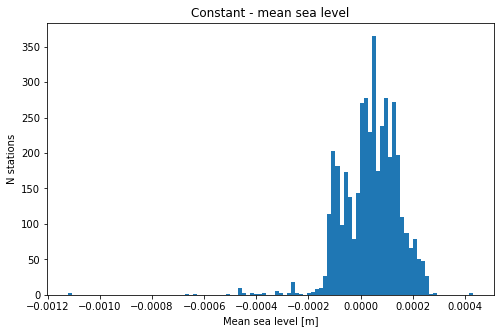

In [12]:
# we don't want the fit of the nodal cycle to result in a different mean, check this.
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(Constant - mean_waterlevel, bins=100);
ax.set_title('Constant - mean sea level')
ax.set_xlabel('Mean sea level [m]')
ax.set_ylabel('N stations');

# Mean sea level map
This map is the mean sea level, taking into account the nodal tide. This map probably correlates to a map of gravity/mass that we used as input. There are a few outliers that have a much higher than average water level.
Also check if the timespan (18 years is causing this). 

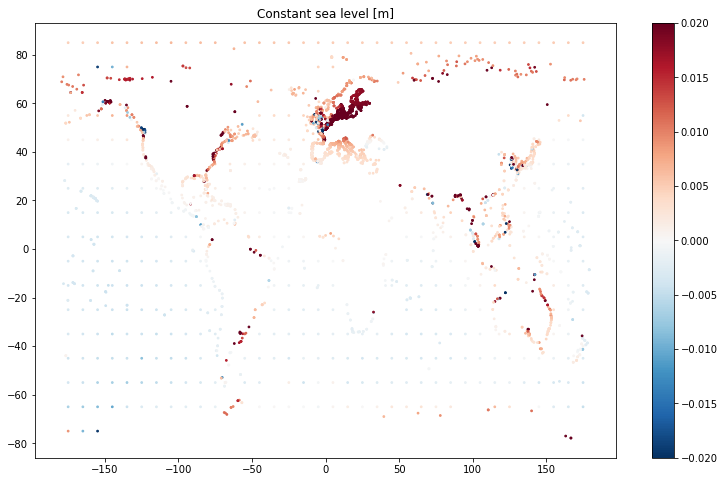

In [13]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.set_title('Constant sea level [m]')
sc = ax.scatter(lon, lat, c=Constant, s=3, vmax=0.02, vmin=-0.02, cmap='RdBu_r', label='Mean sea level [m]')
plt.colorbar(sc, ax=ax, )

# Nodal phase map
This map is the nodal cycle phase. This map probably shows a strong correlation with the [equilibrium](https://www.researchgate.net/profile/Phajm_Gelder/publication/236019217_The_Effect_of_the_186-Year_Lunar_Nodal_Cycle_on_Regional_Sea-Level_Rise_Estimates/links/0deec533fc3c070917000000/The-Effect-of-the-186-Year-Lunar-Nodal-Cycle-on-Regional-Sea-Level-Rise-Estimates.pdf) (figure 4c) tide. Points are scaled with their amplitude so you don't see colors for points without nodal tide, where the phase is random. 

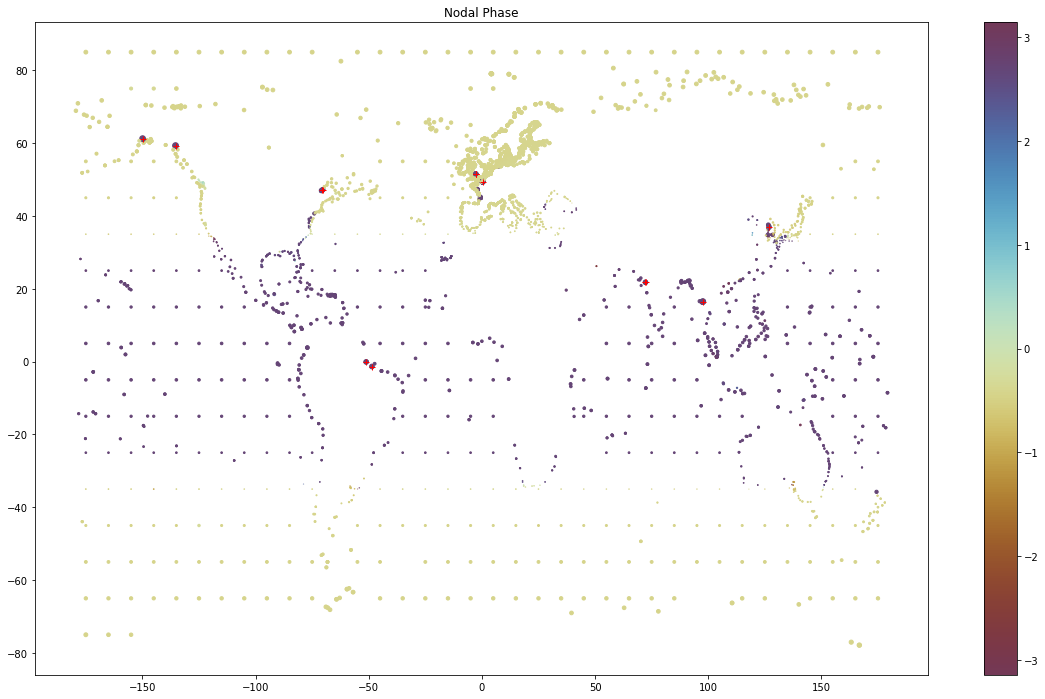

In [14]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.set_title('Nodal Phase')
sc = ax.scatter(lon, lat,  c=phase, cmap=romaO, vmin=-np.pi, vmax=np.pi, s=amplitude * 1000)
plt.colorbar(sc, ax=ax)

# show extreme locations that deviate from equilibrium and need to be investigated
top_n = df.sort_values('amplitude', ascending=False).query('amplitude > 0.018')
ax.plot(top_n['lon'], top_n['lat'], 'r+')

#add ldb (useful for zoomed plot)
if 0:
    from dfm_tools.io.polygon import Polygon
    file_pol = data_dir + '/world.ldb'
    pol_data_list, pol_name_list, pol_comment_list = Polygon.fromfile(file_pol, pd_output=False)
    for iP, pol_data in enumerate(pol_data_list):
        ax.plot(pol_data[:,0],pol_data[:,1],'-k',linewidth=0.5)
    ax.set_ylim(-0,65)
    ax.set_xlim(-80,140)
    #europe
    #ax.set_ylim(44,53)
    #ax.set_xlim(-10,5)

#western canada (high amp and out of phase): two stations in long and shallow sea arms, not sure why there is a high
#chesepeake bay (out of phase with latitude): due to inlet location
#black sea (out of phase with latitude and Medsea): probably because inlet is closed off
#west of south korea (part of bay is out of phase with latitude): could be due to inlet latitude, but not all points are out of phase. SK coastal points also have high amplitude
#europe (several stations in bays that have high amplitude and are out of phase): shallow stations?

#only high amplitude stations (not checked yet, but validated with timeseries in a different plot): Brazil, west of india, Bangladesh/Myanmar

# Nodal amplitude map
This map is the nodal cycle amplitude. You expect to see higher amplitude at the equator and higher towards the higher latitudes.



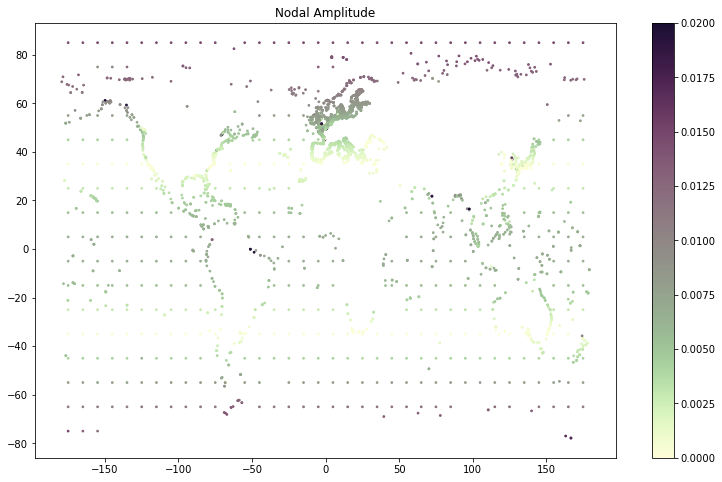

In [15]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.set_title('Nodal Amplitude')
im = ax.scatter(lon, lat,  c=amplitude, cmap=tokyo_r, vmin=0, vmax=0.02, s=3, label='amplitude')
plt.colorbar(im, ax=ax)


# Amplitude and phase as a function of latitude
The figures below show the amplitude and phase as a function of latitude. This should be a squared sine function (or something like that) and a dichotomous phase plot, where the equator is in opposite phase.  We see a few points on the east US coast (Chessapeake Bay) that are in the opposite phase from equilibrium. 

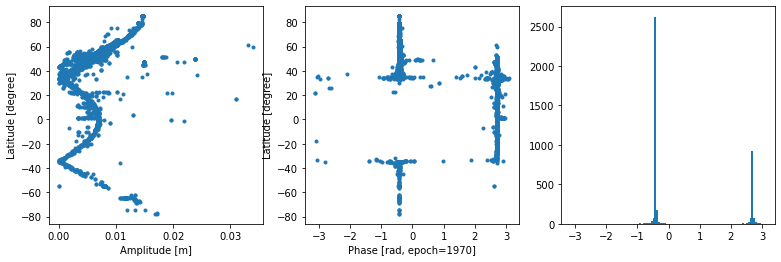

In [16]:
fig, axes = plt.subplots(ncols=3, figsize=(13, 4))
axes[0].plot(amplitude, lat, '.');
axes[0].set_xlabel('Amplitude [m]')
axes[0].set_ylabel('Latitude [degree]')
axes[1].plot(phase, lat, '.');
axes[1].set_xlabel('Phase [rad, epoch=1970]')
axes[1].set_ylabel('Latitude [degree]')
axes[2].hist(phase, bins=100);


In [17]:
df2 = pd.DataFrame(data=dict(lat=lat, lon=lon, amplitude=amplitude))
#df2 = pd.DataFrame(data=dict(lat=lat, lon=lon, amplitude=amplitude))
#if 'stations_pd' in locals():
#    df2['station_name'] = stations_pd.loc[:,'station_id']
df2_sortamp = df.sort_values('amplitude', ascending=False).head(n=20)
df2_sortamp

,lat,lon,dep,mean_waterlevel,amplitude,station_name
3032,59.326171,-135.366211,-11.571979,1.163982,0.033994,psmsl-495
3435,61.245114,-149.912109,-7.503355,1.380460,0.033137,psmsl-1067
603,16.479492,97.602539,-8.821159,1.512246,0.030938,moulmein
3941,36.958007,126.811523,-11.777194,0.715108,0.024142,psmsl-1908
1068,49.445801,0.314941,-5.852910,0.700016,0.023753,IBIS_GL_TS_MO_62449
3395,47.006835,-70.825195,-10.263537,0.444866,0.021914,psmsl-999
3094,-1.333008,-48.588867,-5.512898,0.294545,0.021890,psmsl-580
3531,47.211913,-70.297852,-6.562790,0.446795,0.020638,psmsl-1223
2972,21.811523,72.290039,-13.223085,0.227833,0.019805,psmsl-420
673,-0.073242,-51.137695,-7.568553,0.280548,0.019668,porto_de_santana


In [18]:
#sort stations on depths, to see if that is an explanation for high nodal amplitudes (however, there are many shallow stations that have a negligible amplitude)
df2_sortdep = df.sort_values('dep', ascending=False).head(n=20)
#df2_sortdep

0
1
4
1


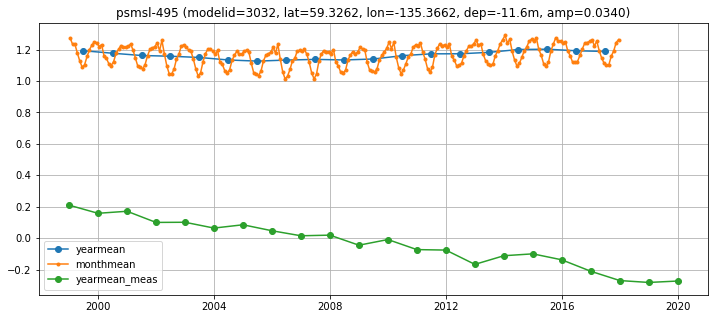

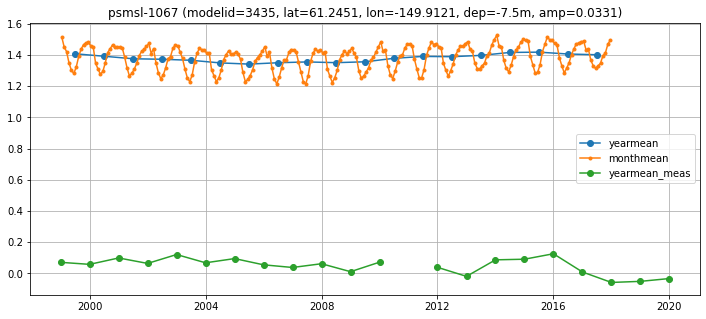

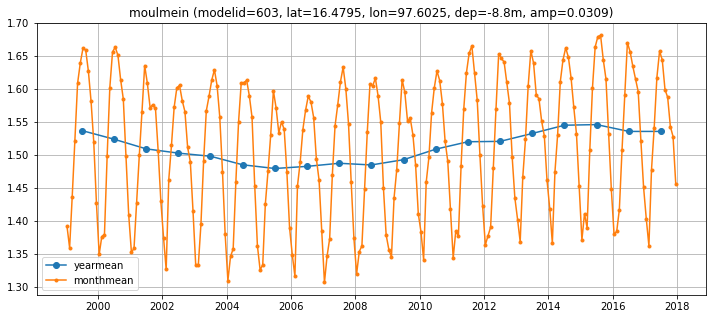

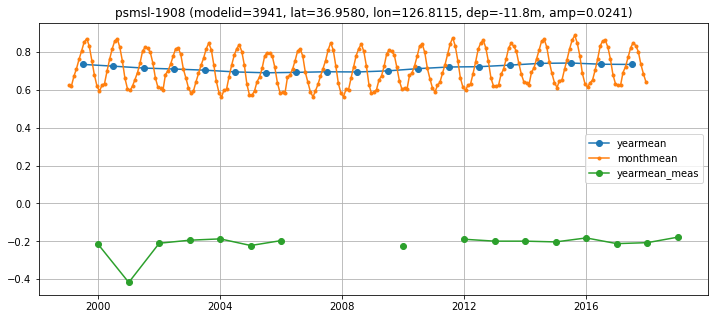

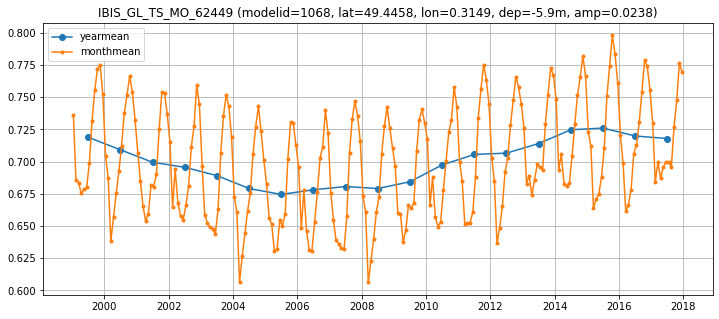

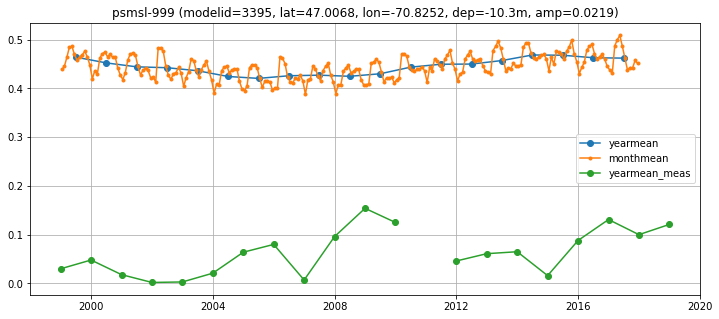

In [34]:
#plot some of the timeseries of outlier stations (higher amplitude than expected).
#First twenty stations indeed show higher amplitude in mean water level
for iR, df2_sortamp_row in df2_sortamp.iloc[:6].iterrows():
    stat_sel = df2_sortamp_row['station_name']
    fig,(ax1) = plt.subplots(1,1, figsize=(12,5))#, gridspec_kw={'height_ratios':[3,1,1]},sharex=True)
    ax1.set_title('%s (modelid=%d, lat=%.4f, lon=%.4f, dep=%.1fm, amp=%.4f)'%(stat_sel,iR, lat[iR], lon[iR], dep[iR], df2_sortamp_row['amplitude']))
    wllines = ax1.plot(ds_mean['time'],ds_mean['waterlevel'][:,iR], 'o-',label='yearmean')
    wllines = ax1.plot(ds_monmean['time'],ds_monmean['waterlevel'][:,iR], '.-',label='monthmean')
    if stat_sel.startswith('psmsl'):
        psmsl_id = int(stat_sel.replace('psmsl-',''))
        meas_stat = measurements[(measurements['station']==psmsl_id) & (measurements.index>=dt.datetime(1999,1,1))]
        #print(psmsl_id)
        #print(meas_stat)
        print(meas_stat['height'].isnull().sum())
        if meas_stat['height'].isnull().sum() < 15:
            ax1.plot(meas_stat['height'], 'o-',label='yearmean_meas')
    ax1.grid()
    ax1.legend()


# Timeseries
Here we visualize all timeseries by computing anomalies per station and sorting them by their latitude. You see the opposite phases around the 40 latitude. 

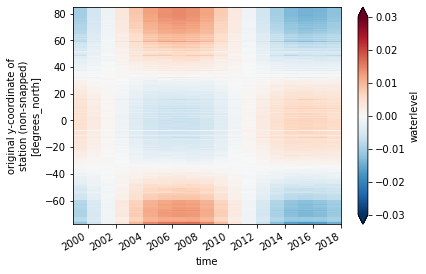

In [20]:
anomaly = (ds_mean.waterlevel - ds_mean.waterlevel.mean(axis=0))
idx = np.argsort(ds_mean.station_y_coordinate.values)
anomaly[:, idx].plot(y='station_y_coordinate', x='time', vmin=-0.03, vmax=0.03, cmap='RdBu_r')
# ds_mean.time[7]


# TODO: Nodal Ampltitude 
Describe spatial pattern, compare with M2 map. 

In [21]:
year_max = np.array([x.year for x in ds_max.waterlevel.time.values.astype('M8[ms]').astype('O')], dtype='double')
year_min = np.array([x.year for x in ds_min.waterlevel.time.values.astype('M8[ms]').astype('O')], dtype='double')

assert np.allclose(year_max, year_min)
year = year_min


In [22]:
X = np.c_[
    np.cos(2*np.pi*(year - 1970)/18.613),
    np.sin(2*np.pi*(year - 1970)/18.613)
]
Y = ds_max.waterlevel.values - ds_min.waterlevel.values
names = ['Constant', 'Nodal U', 'Nodal V']
X = sm.add_constant(X)
model = sm.OLS(Y, X, missing='drop')
fit = model.fit()
A = fit.params[1]
B = fit.params[2]
phase_minmax = np.arctan2(B,  A)
amplitude_minmax = np.sqrt(A**2 + B**2)

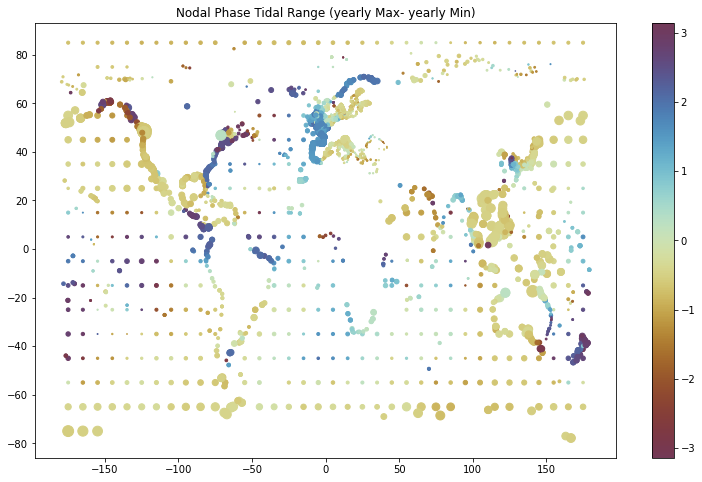

In [23]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.set_title('Nodal Phase Tidal Range (yearly Max- yearly Min)')
sc = ax.scatter(lon, lat,  c=phase_minmax, cmap=romaO, vmin=-np.pi, vmax=np.pi, s=amplitude_minmax * 500)
plt.colorbar(sc, ax=ax)

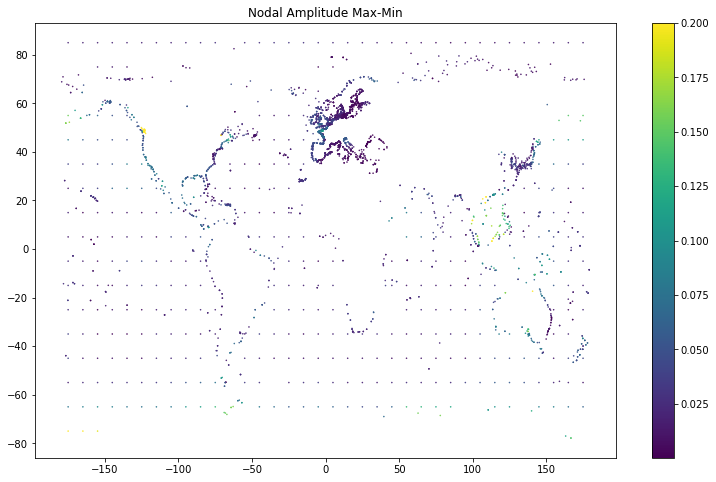

In [24]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.set_title('Nodal Amplitude Max-Min')
im = ax.scatter(lon, lat,  c=amplitude_minmax, cmap='viridis', vmax=0.2, s=0.3, label='amplitude_minmax')
plt.colorbar(im, ax=ax)

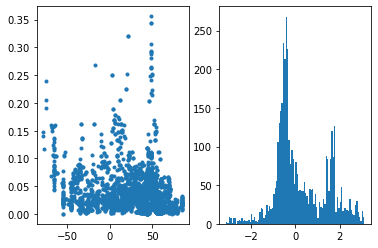

In [25]:
fig, axes = plt.subplots(ncols=2)
axes[0].plot(lat, amplitude_minmax, '.');
axes[1].hist(phase_minmax, bins=100);